In [1]:
import numpy as np
import pandas as pd

In [2]:
binscheme = {
    "x": [0.0, 0.5,  1.0, 1.5,  2.0],
    "y": [0.0, 1.0,  2.0, 3.0,  4.0],
    "z": [0.0, 0.25, 0.5, 0.75, 1.0]
}

In [3]:
def get_binscheme_cuts_and_ids(
        binscheme,
        start_idx=0,
        id_key='bin_id'
    ):
    """
    Parameters
    ----------
    binscheme : required, dict
        Dictionary mapping binning variables to bin limits arrays
    start_idx : optional, int
        Starting integer for enumerating bin unique integer ids
        Default : 0
    id_key : optional, string
        Column name for bin unique integer ids
        Default : 'bin_id'

    Returns
    -------
    (dict, pandas.DataFrame)
        Dictionary of bin ids to cuts and a pandas dataframe with bin ids under `id_key` and
        the projection bin ids under the respective variable names.

    Description
    -----------
    Create a map of bin ids to bin cuts and a data frame mapping bin ids to projection bin ids.
    """

    # Initialize arrays
    cuts = []
    ids  = []

    # Loop bin variables
    for var in binscheme:

        # Get bin variable limits, projection ids, and cuts
        nbins = len(binscheme[var])-1
        lims = binscheme[var]
        if type(binscheme[var])==dict and 'nbins' in binscheme[var].keys() and 'lims' in binscheme[var].keys():
            nbins = binscheme[var]['nbins']
            lims = [(binscheme[var]['lims'][1]-binscheme[var]['lims'][0])/nbins * i + binscheme[var]['lims'][0] for i in range(nbins+1)]
        varlims = [[lims[idx],lims[idx+1]] for idx in range(nbins)]
        varids  = [i for i in range(nbins)]
        varcuts = [f"({var}>={varlims[idx][0]} && {var}<{varlims[idx][1]})" for idx in range(nbins)]

        # Expand bin cuts and projection ids maps
        cuts = [f"{varcut} && {cut}" for varcut in varcuts for cut in cuts] if len(cuts)>0 else varcuts
        ids  = [dict({var:varid},**id_map) for varid in varids for id_map in ids] if len(ids)>0 else [{var:el} for el in varids]

    # Turn cuts into a map of bin ids to cuts
    cuts = {start_idx+idx: cuts[idx] for idx in range(len(cuts))}

    # Set up data frame
    df = {id_key:[]}
    for var in binscheme:
        df[var] = []

    # Add data frame entries
    for idx in range(len(ids)):
        binscheme_binid = idx + start_idx
        df[id_key].append(binscheme_binid)
        for var in binscheme:
            df[var].append(ids[idx][var])

    #  Create pandas data frame
    df = pd.DataFrame(df)

    return cuts, df



In [4]:
_cuts, _ids = get_binscheme_cuts_and_ids(binscheme,start_idx=0)

In [5]:
def get_projection_ids(df,proj_vars,id_key='bin_id',other_var_bins={}):

    # Check projection variables
    if len(proj_vars)>2:
        print('WARNING: `get_projection_ids` : Are you sure you want more than 2 projection variables?')

    # Get list of grouping variables
    other_vars = []
    for key in df.keys():
        if (key!=id_key and key not in proj_vars and key not in other_var_bins.keys()): other_vars.append(key)

    # Check grouping variables
    if len(other_vars)==0:
        return [df.sort_values(proj_vars)[id_key].values.tolist()], othervars, []

    # Check other variable bins argument
    if np.any([el in other_var_bins for el in other_var_bins]):
        raise TypeError('`proj_vars` entries are not allowed in `other_var_bins`.')

    # Get cut for other variable bins
    other_var_bins_cut = ' and '.join([f'{key}=={other_var_bins[key]}' for key in other_var_bins])

    # Get unique projection bin ids for each projection variable
    unique_bin_ids = [df[var].unique() for var in proj_vars]
    nbins = [len(el) for el in unique_bin_ids]

    # Get map of starting bins and bin and projection indices
    query = ' and '.join([f'{proj_var}=={0}' for proj_var in proj_vars])
    if other_var_bins_cut!='': query = ' and '.join([query,other_var_bins_cut])
    start_bins_slice = df.query(query)

    # Loop starting bins and create projection lists
    all_proj_ids = []
    all_proj_other_var_ids = []
    for proj_idx in range(len(start_bins_slice)):

        # Find bins that match starting bin in other bin variable indices
        other_var_ids = [start_bins_slice[other_var].iloc[proj_idx] for other_var in other_vars]
        query = ' and '.join([f'{other_vars[idx]}=={other_var_ids[idx]}' for idx in range(len(other_var_ids))])
        if other_var_bins_cut!='': query = ' and '.join([query,other_var_bins_cut])
        proj_ids = df.query(query)
        proj_ids = proj_ids.sort_values(proj_vars)[id_key].values #NOTE: SORT BY PROJECTION VARIABLE BINS
        # print("DEBUGGING: type(proj_ids) = ",type(proj_ids))
        print("DEBUGGING: BEFORE RESHAPE: proj_ids       = ",proj_ids)
        proj_ids = proj_ids.reshape(nbins) #NOTE: RESIZE BY APPROPRIATE NUMBER OF BINS IF REQUESTED.
        print("DEBUGGING: AFTER RESHAPE: proj_ids       = ",proj_ids)
        all_proj_ids.append(proj_ids.tolist())
        all_proj_other_var_ids.append(other_var_ids)

    return all_proj_ids, other_vars, all_proj_other_var_ids


In [6]:
proj_vars = ['x','y']
get_projection_ids(_ids,proj_vars)


DEBUGGING: BEFORE RESHAPE: proj_ids       =  [ 0  4  8 12  1  5  9 13  2  6 10 14  3  7 11 15]
DEBUGGING: AFTER RESHAPE: proj_ids       =  [[ 0  4  8 12]
 [ 1  5  9 13]
 [ 2  6 10 14]
 [ 3  7 11 15]]
DEBUGGING: BEFORE RESHAPE: proj_ids       =  [16 20 24 28 17 21 25 29 18 22 26 30 19 23 27 31]
DEBUGGING: AFTER RESHAPE: proj_ids       =  [[16 20 24 28]
 [17 21 25 29]
 [18 22 26 30]
 [19 23 27 31]]
DEBUGGING: BEFORE RESHAPE: proj_ids       =  [32 36 40 44 33 37 41 45 34 38 42 46 35 39 43 47]
DEBUGGING: AFTER RESHAPE: proj_ids       =  [[32 36 40 44]
 [33 37 41 45]
 [34 38 42 46]
 [35 39 43 47]]
DEBUGGING: BEFORE RESHAPE: proj_ids       =  [48 52 56 60 49 53 57 61 50 54 58 62 51 55 59 63]
DEBUGGING: AFTER RESHAPE: proj_ids       =  [[48 52 56 60]
 [49 53 57 61]
 [50 54 58 62]
 [51 55 59 63]]


([[[0, 4, 8, 12], [1, 5, 9, 13], [2, 6, 10, 14], [3, 7, 11, 15]],
  [[16, 20, 24, 28], [17, 21, 25, 29], [18, 22, 26, 30], [19, 23, 27, 31]],
  [[32, 36, 40, 44], [33, 37, 41, 45], [34, 38, 42, 46], [35, 39, 43, 47]],
  [[48, 52, 56, 60], [49, 53, 57, 61], [50, 54, 58, 62], [51, 55, 59, 63]]],
 ['z'],
 [[0], [1], [2], [3]])

In [7]:
# _ids[np.all([df[df[other_vars[idx]]]==other_var_ids[idx] for idx in range(len(other_var_ids))])]

In [8]:
sep = '_'
els = [str(i) for i in range(5)]
print("DEBUGGING: els = ",els)
sep2 = sep+sep
(sep+sep).join(els)

DEBUGGING: els =  ['0', '1', '2', '3', '4']


'0__1__2__3__4'

In [9]:
def get_graph_data(
                    df,
                    bin_ids,
                    id_key,
                    xvar_keys=['x'],
                    asym_key='a1',
                    err_ext='_err'
    ):
    """
    Parameters
    ----------
    df : required, pandas.DataFrame
        Pandas dataframe containing bin ids and data
    bin_ids : required, list
        List of unique integer bin ids
    id_key : required, string
        String identifier for bin id column
    xvar_keys : list, optional
        List of binning variables for which to return mean values
        Default : ['x']
    asym_key : string, optional
        Asymmetry variables for which to return mean value
        Default : 'a1'
    err_ext : string, optional
        Extension for forming error column names
        Default : '_err'

    Returns
    -------
    np.array
        Numpy array containing graph data with dimensions `(2*(1+N_XVAR_KEYS),*SHAPE(BIN_IDS))`

    Description
    -----------
    Read graph data for a projection plot from a pandas dataframe.
    """

    # Initialize arrays
    y    = []
    yerr = []
    x    = []
    xerr = []

    # Check if bin_ids is multi-dimensional
    bin_ids_shape = np.shape(bin_ids)
    if len(bin_ids_shape)>1:
        bin_ids = np.flatten(bin_ids)

    # Loop bins
    for bin_raw_idx, bin_id in enumerate(bin_ids):

        # Get bin data
        bin_data = df.loc[df[id_key]==bin_id]

        # Get bin asymmetry value and error
        y.append(bin_data[asym_key])
        yerr.append(bin_data[asym_key+err_ext])

        # Loop bin variables
        for xvar_idx, xvar in enumerate(xvar_keys):

            # Get bin variable data
            bin_x = bin_data[xvar_key]
            bin_x_err = bin_data[xvar_key+err_ext]

            # Add bin variable mean and error
            if bin_raw_idx==0:
                x.append([bin_x])
                xerr.append([bin_x_err])
            else:
                x[xvar_idx].append(bin_x)
                xerr[xvar_idx].append(bin_x_err)

    # Reshape data
    if len(bin_ids_shape)>1:

        # Reshape bin asymmetry value and error
        y    = np.reshape(y,bin_ids_shape)
        yerr = np.reshape(yerr,bin_ids_shape)

        # Reshape bin variable statistics
        for xvar_idx, xvar in enumerate(xvar_keys):
            x[xvar_idx]    = np.reshape(x[xvar_idx],bin_ids_shape)
            xerr[xvar_idx] = np.reshape(xerr[xvar_idx],bin_ids_shape)

    return np.array([
        y,
        yerr,
        *x,
        *xerr
    ])

In [10]:
def get_aggregate_graph(
        graph_list,
        xvar_keys=['x'],
        asym_key='a1',
        err_ext='_err',
        sgasym=0.0,
    ):
    """
    Parameters
    ----------
    graph_list : required, list
        List of graphs with dimension `(N_GRAPHS, 2*(1+N_XVAR_KEYS), N_BIN_IDS)`
    xvar_keys : list, optional
        List of binning variables for which to return mean values
        Default : ['x']
    sgasym : optional, float
        Injected signal asymmetry for computing difference of measured and injected values

    Returns
    -------
    Dictionary
        Dictionary of mean asymmetry means and errors and other statistics names as well as bin variable means and errors to an array of their values in each kinematic bin

    Description
    -----------
    Compute the mean bin variables and asymmetry means and errors and other statistical information across a list of graphs' data from `get_graph_data()`.
    Note that in the case of that the graph dimension is greater than 1, the bin variable statistics will be returned as a list of arrays in the same order as `xvar_keys`.
    """

    # Setup return dictionary
    graph = {
            'y_mean':[],
            'yerr_mean':[],
            'y_std':[],
            'y_min':[],
            'y_max':[],
            'ydiff_mean':[],
            'ydiff_std':[],
            'ydiff_min':[],
            'ydiff_max':[],
            'x_mean':[],
            'xerr_mean':[]
            }

    # Check if graph list is empty
    if len(graph_list)==0:
        print("WARNING: len(graph_list)==0.  Returning empty graph.")
        return graph

    # Format graph list
    graph_list  = np.array(graph_list)
    graph_list  = np.swapaxes(graph_list,0,1) #NOTE: INCOMING LIST SHOULD GO FROM DIMENSION (N_GRAPHS, 2*(1+N_XVAR_KEYS), N_BIN_IDS) -> (2*(1+N_XVAR_KEYS), N_GRAPHS, N_BIN_IDS)

    # Extract aggregate asymmetry statistics
    y_idx    = 0
    yerr_idx = 1
    graph['y_mean']     = np.mean(graph_list[y_idx],axis=0)
    graph['yerr_mean']  = np.sqrt(np.mean(np.square(graph_list[yerr_idx]),axis=0))
    graph['y_std']      = np.std(graph_list[y_idx],axis=0)
    graph['y_min']      = np.min(graph_list[y_idx],axis=0)
    graph['y_max']      = np.max(graph_list[y_idx],axis=0)
    graph['ydiff_mean'] = np.mean(graph_list[y_idx]-sgasym,axis=0)
    graph['ydiff_std']  = np.std(graph_list[y_idx]-sgasym,axis=0)
    graph['ydiff_min'] = np.min(graph_list[y_idx]-sgasym,axis=0)
    graph['ydiff_max'] = np.max(graph_list[y_idx]-sgasym,axis=0)

    # Extract aggregate projection variable statistics
    x_idx_start    = 2
    xerr_idx_start = x_idx_start+len(xvar_keys)
    if len(xvar_keys)==1:

        # Set projection variable arrays in the case of a 1D binning
        x_idx = x_idx_start
        xerr_idx = xerr_idx_start
        graph['x_mean']     = np.mean(graph_list[x_idx],axis=0) #NOTE: Get mean across different graphs (axis=0) but not across bins (axis>0)
        graph['xerr_mean']  = np.sqrt(np.mean(np.square(graph_list[xerr_idx]),axis=0))
    else:

        # Loop projection variable keys and aggregate across each variable for a >1D binning
        for xvar_idx, xvar in enumerate(xvar_keys):
            x_idx = x_idx_start + xvar_idx
            xerr_idx = xerr_idx_start + xvar_idx
            graph['x_mean'].append(np.mean(graph_list[x_idx],axis=0))
            graph['xerr_mean'].append(np.sqrt(np.mean(np.square(graph_list[xerr_idx]),axis=0)))

    return graph




In [11]:
ngraphs = 16
graph_increment = 0.01

# Graph data 1D
y = np.array([1.0, 0.5, 0.0, -0.5])
yerr = np.array([0.05+0.005*i for i in range(len(y))])
x = [0.25, 0.75, 1.25,  1.75]
xerr = [0.01*i for i in range(len(x))]
graph_list = [
    np.array([
        y+graph_increment*i,
        yerr+graph_increment*i,
        x,#NOTE: 1D
        xerr,#NOTE: 1D
    ]) for i in range(ngraphs)
]

# # Graph data 2D
# ybins = 4
# y = np.array([[1.0, 0.5, 0.0, -0.5] for j in range(ybins)])
# yerr = np.array([[0.05+0.005*i for i in range(len(y))] for j in range(ybins)])
# x = [[0.25, 0.75, 1.25,  1.75] for j in range(ybins)]
# xerr = [[0.01*i for i in range(len(x))] for j in range(ybins)]
# z = [[0.25, 0.75, 1.25,  1.75] for j in range(ybins)]
# zerr = [[0.01*i for i in range(len(x))] for j in range(ybins)]
# graph_list = [
#     np.array([
#         y+graph_increment*i,
#         yerr+graph_increment*i,
#         x,#NOTE: 2D
#         z,#NOTE: 2D
#         xerr, #NOTE: 2D
#         zerr, #NOTE: 2D
#     ]) for i in range(ngraphs)
# ]

In [12]:
graph = get_aggregate_graph(
        graph_list,
        xvar_keys=['x'], # ['x','z'],
        sgasym=0.0,
    )

In [13]:
import matplotlib.pyplot as plt

def save_txt(
        filename,
        data,
        delimiter=",",
        header=None,
        fmt=None,
        comments='',
    ):
    """
    Parameters
    ----------
    filename : required, string
        Output file name
    data : array, required
        2D data array with dimensions `[N_COLUMNS,N_ROWS]` TODO CHECK THIS!!!
    delimiter : optional, string
        CSV format delimiter
        Default : ","
    header : optional, string
        CSV header
        Default : None
    fmt : optional, string
        CSV column formats
        Default : None
    comments : optional, string
        CSV comments
        Default : ""

    Description
    -----------
    Save a square data array of dimensions `[N_COLUMNS,N_ROWS]` to a text file.  TODO CHECK THIS!!!
    """

    # Save to CSV
    if header is None: header = ' '+delimiter+delimiter.join([str(i+1) for i in range(len(data))])#NOTE: ASSUME DATA HAS DIMENSION: [NCOL,NROWS]
    header = "REPLACEMENT_HEADER"+header
    np.savetxt(filename, data, header=header, delimiter=delimiter, fmt=fmt, comments=comments)

    # Read in the file
    with open(filename, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('# REPLACEMENT_HEADER', '')

    # Write the file out again
    with open(filename, 'w') as file:
        file.write(filedata)

def save_graph_to_csv(
        filename,
        x,
        y,
        xerr=None,
        yerr=None,
        xerr_syst=None,
        yerr_syst=None,
        delimiter=",",
        header=None,
        fmt=None,
        comments='',
    ):

    """
    Parameters
    ----------
    filename : required, string
        Output file name
    x : required, list
        Graph x values
    y : required, list
        Graph y values
    xerr : optional, list
        Graph x error values
        Default : None
    yerr : optional, list
        Graph y error values
        Default : None
    xerr_syst : optional, list
        Graph x systematic error values
        Default : None
    yerr_syst : optional, list
        Graph y systematic error values
        Default : None
    delimiter : optional, string
        CSV format delimiter
        Default : ","
    header : optional, string
        CSV header
        Default : None
    fmt : optional, string
        CSV column formats
        Default : None
    comments : optional, string
        CSV comments
        Default : ""

    Description
    -----------
    Write a graph to a CSV file with optional errors and systematic errors.
    """

    # Create data array
    data = []
    if xerr is None or len(xerr)==0: xerr = [0.0 for el in x]
    if yerr is None or len(yerr)==0: yerr = [0.0 for el in x]
    if xerr_syst is None or len(xerr_syst)==0: xerr_syst = [0.0 for el in x]
    if yerr_syst is None or len(yerr_syst)==0: yerr_syst = [0.0 for el in x]
    for i, el in enumerate(x):
        data.append([i, x[i], y[i], xerr[i], yerr[i], xerr_syst[i], yerr_syst[i]])
    data = np.array(data)

    # Save data to file
    save_txt(filename, data, header=header, delimiter=delimiter, fmt=fmt, comments=comments)

def plot_results(
        x_mean = None,
        y_mean = None,
        xerr_mean = None,
        yerr_mean = None,
        xerr_syst = None,
        yerr_syst = None,
        y_min  = None,
        y_max  = None,
        y_std  = None,
        ydiff_mean = None,
        ydiff_std = None,
        ydiff_min = None,
        ydiff_max = None,
        dist_hists = {},
        xlims = [0.0,1.0],
        ylims = [-1.0,1.0],
        title = 'Asymmetry Results',
        xvar  = 'x',
        xtitle = '$x$',
        ytitle = '$\mathcal{A}$',
        sgasym = 0.10,
        bgasym = 0.00,
        color  = 'blue', #NOTE: COLOR OF DATA POINTS
        bcolor = 'gray', #NOTE:
        outpath = 'out.pdf',
        add_clas12_watermark = True,
        show_injected_asymmetries = False,
    ):
    """
    Parameters
    ----------
    x_mean : list, optional
        x mean values for each bin
        Default : None
    y_mean : list, optional
        y mean values for each bin
        Default : None
    xerr_mean : list, optional
        x error alues for each bin
        Default : None
    yerr_mean : list, optional
        y error values for each bin
        Default : None
    xerr_syst : list, optional
        x systematic error alues for each bin
        Default : None
    yerr_syst : list, optional
        y systematic error values for each bin
        Default : None
    y_min : list, optional
        y minimum values for each bin
        Default : None
    y_max : list, optional
        y maximum values for each bin
        Default : None
    y_std : list, optional
        y standard deviation values for each bin
        Default : None
    ydiff_mean : list, optional
        y difference from injected signal asymmetry mean values for each bin
        Default : None
    ydiff_std : list, optional
        y difference from injected signal asymmetry standard deviation values for each bin
        Default : None
    ydiff_min : list, optional
        y difference from injected signal asymmetry minimum values for each bin
        Default : None
    ydiff_max : list, optional
        y difference from injected signal asymmetry maximum values for each bin
        Default : None
    xlims : tuple, optional
        x limits for plotting
        Default : (0.0,1.0)
    ylims : tuple, optional
        y limits for plotting
        Default : (-1.0,1.0)
    title : string, optional
        Plot title
        Default : 'x'
    xvar : string, optional
        Bin variable name
        Default : 'x'
    xtitle : string, optional
        x axis title
        Default : '$x$'
    ytitle : string, optional
        y axis title
        Default : '$\Delta \mathcal{A}$'
    sgasym : float, optional
        Injected signal asymmetry
        Default : 0.10
    bgasym : float, optional
        Injected background asymmetry
        Default : 0.00
    color : string, optional
        Color of data point markers
        Default : 'blue'
    bcolor : string, optional
        Color of standard or min max band
        Default : 'gray'
    outpath : string, optional
        Name of output pdf
        Default : 'systematics.pdf'
    add_clas12_watermark : Boolean, optional
        Option to add CLAS12 watermark on produced plot
        Default : True
    show_injected_asymmetries : Boolean, optional
        Option to show injected signal and background asymmetries
        Default : False

    Description
    -----------
    Plot the results for each bin in a 1D binning scheme showing systematic errors
    and a standard deviation band and injected asymmetries if desired.  Save results
    and systematics to CSV.
    """

    # Set font sizes
    plt.rc('font', size=25) #controls default text size
    plt.rc('axes', titlesize=50) #fontsize of the title
    plt.rc('axes', labelsize=50) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
    plt.rc('legend', fontsize=20) #fontsize of the legend

    # Get some nicer plot settings
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True

    ecolor='black'
    elinewidth=2.0
    capsize=18
    capthick=2.0
    marker='o'
    linestyle=None
    linewidth=0.0
    markersize=20
    gridlinewidth=0.5
    axlinewidth=1

    # Set up plot
    figsize = (16,10)
    f1, ax1 = plt.subplots(figsize=figsize)
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.title(title,usetex=True)
    plt.xlabel(xtitle,usetex=True)
    plt.ylabel(ytitle,usetex=True)

    # Plot systematics OR std deviation of aggregated injected values THEN data with errors
    if yerr_syst is not None:
        g1 = plt.errorbar(x_mean,y_mean,xerr=None,yerr=yerr_syst,
                    ecolor='gray', elinewidth=elinewidth*20, capsize=0,
                    color=color, marker='o', linestyle=linestyle, alpha=0.5,
                    linewidth=0, markersize=0,label='Systematic error')

    # Plot standard deviation of repetitions in each bin
    if y_std is not None:
        print("DEBUGGING: y_std           = ",y_std)
        print("DEBUGGING: type(y_std)     = ",type(y_std))
        print("DEBUGGING: np.shape(y_std) = ",np.shape(y_std))
        fb = plt.fill_between(x_mean, np.add(y_mean,y_std), np.add(y_mean,-y_std), alpha=0.2, label='$\pm1\sigma$ Band', color=bcolor)

    # Plot results
    g2 = plt.errorbar(x_mean,y_mean,xerr=xerr_mean,yerr=yerr_mean,
                        ecolor=ecolor, elinewidth=elinewidth, capsize=capsize,
                        color=color, marker='o', linestyle=linestyle,
                        linewidth=linewidth, markersize=markersize,label=ytitle)

    # Set tick marks and zero line
    plt.tick_params(direction='out',bottom=True,top=True,left=True,right=True,length=10,width=1)
    ax1.axhline(0, color='black',linestyle='-',linewidth=axlinewidth)

    # Draw injected asymmetries
    if show_injected_asymmetries:
        if sgasym!=0: ax1.axhline(0, color='black',linestyle='-',linewidth=axlinewidth)
        ax1.axhline(sgasym, color='red',linestyle='--',linewidth=axlinewidth, label='Injected Signal Asymmetry')
        if bgasym!=0: ax1.axhline(bgasym, color='blue',linestyle='--',linewidth=axlinewidth, label='Injected Background Asymmetry')

    # Add water mark and legend
    if add_clas12_watermark:
        plt.text(0.5, 0.5, 'CLAS12 Preliminary',
                size=50, rotation=25., color='gray', alpha=0.25,
                horizontalalignment='center',verticalalignment='center',transform=ax1.transAxes)
    plt.legend(loc='best')

    # Save figure
    f1.savefig(outpath)

    # Save plot data to csv
    delimiter = ","
    header    = delimiter.join(["bin","x","y","xerr","yerr","xerrsyst","yerrsyst"]) #NOTE: CAN'T HAVE UNDERSCORE IN COLUMN NAMES FOR LATEX CSVSIMPLE
    fmt       = ["%d","%.3g","%.3g","%.3g","%.3g","%.3g","%.3g"]
    comments  = ""

    # Save plot data
    save_graph_to_csv(
        outpath+'.csv',
        x_mean,
        y_mean,
        xerr=xerr_mean,
        yerr=yerr_mean,
        xerr_syst=xerr_syst,
        yerr_syst=yerr_syst,
        delimiter=delimiter,
        header=header,
        fmt=fmt,
        comments=comments
        )

    # Save ydiffs for MC asym injection systematics
    if ydiff_mean is not None:
        save_graph_to_csv(
            outpath+'_ydiff.csv',
            x_mean,
            ydiff_mean,
            xerr=xerr_mean,
            yerr=ydiff_std,
            delimiter=delimiter,
            header=header,
            fmt=fmt,
            comments=comments
        )


DEBUGGING: y_std           =  [0.04609772 0.04609772 0.04609772 0.04609772]
DEBUGGING: type(y_std)     =  <class 'numpy.ndarray'>
DEBUGGING: np.shape(y_std) =  (4,)


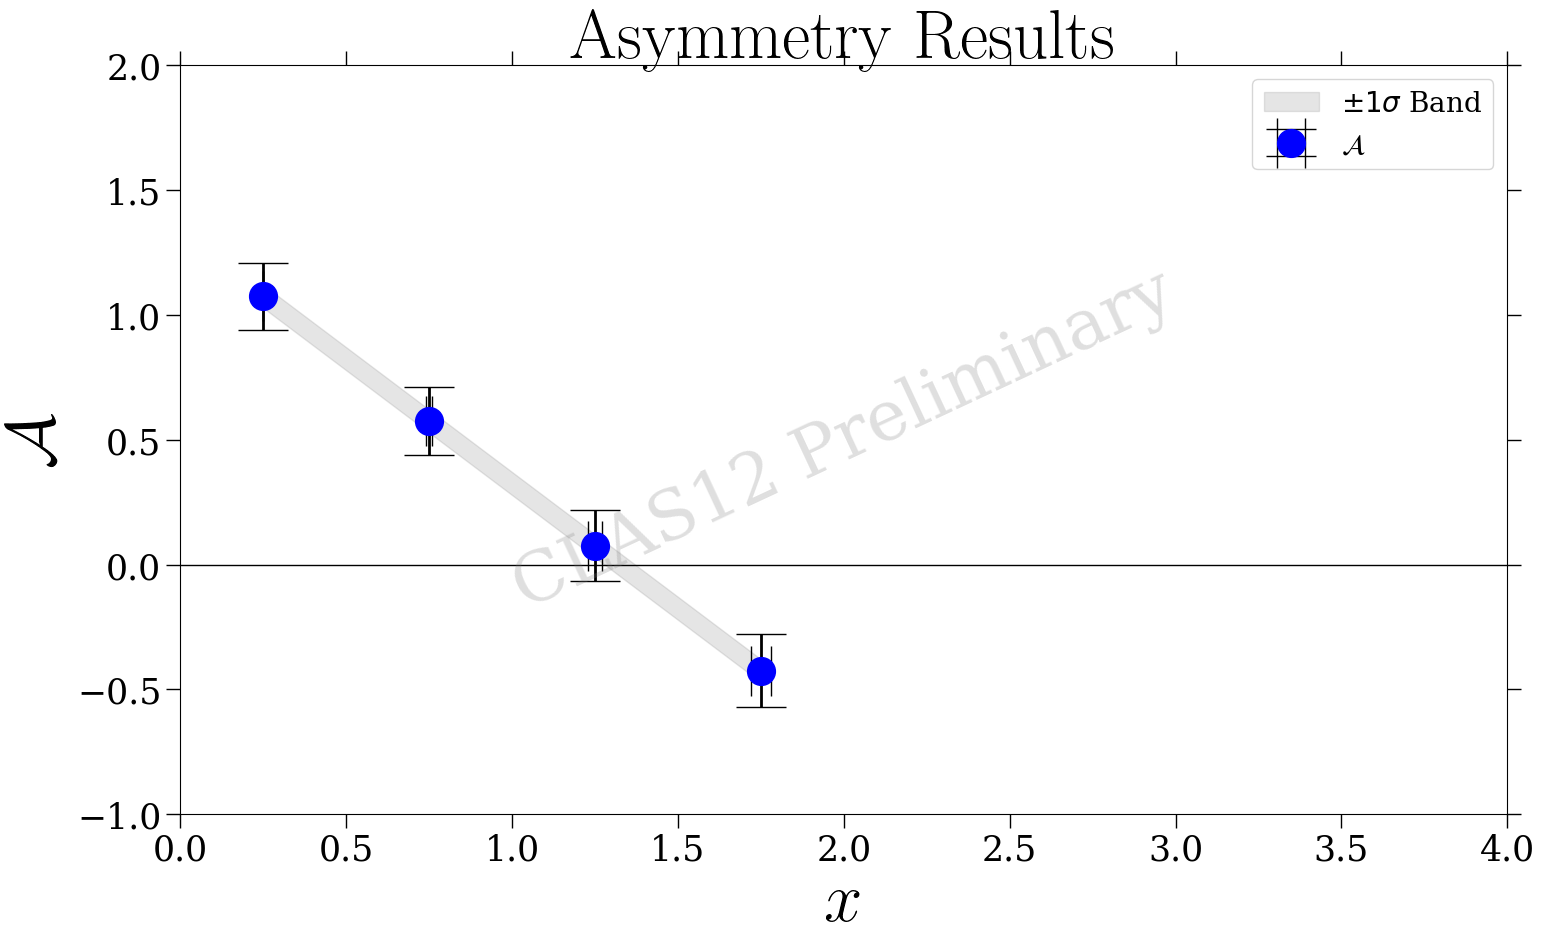

In [14]:
plot_results(**graph,ylims=[-1.0,2.0],xlims=[0.0,4.0])

In [15]:
print(graph['x_mean'])

[0.25 0.75 1.25 1.75]


In [16]:
# f, a = plt.subplots()
# h = a.hist([0.1*i for i in range(11)])
# print(type(a))
# print(type(h[0]))
# print(type(h[1]))
# print(type(h[2]))
# print(type(h[3]))

In [17]:
a = []
a[1:-1]

[]

In [18]:
a = np.array([[0.1*i for i in range(10)],[-0.1*i for i in range(10)]])

In [19]:
# m = {}
# m[a] = 1

In [20]:
b = [[{"a":1, "b":2} for j in range(3)] for i in range(5)]
np.shape(b)

(5, 3)

In [21]:
import sys
sys.path.append("/Users/mfm45/saga/py")
import saga.aggregate_NEW as sagas

DEBUGGING: graph_array[ 0 ][ 0 ] =  {'y_mean': array([ 1.075,  0.575,  0.075, -0.425]), 'yerr_mean': array([0.13322913, 0.13793114, 0.14265343, 0.14739403]), 'y_std': array([0.04609772, 0.04609772, 0.04609772, 0.04609772]), 'y_min': array([ 1. ,  0.5,  0. , -0.5]), 'y_max': array([ 1.15,  0.65,  0.15, -0.35]), 'ydiff_mean': array([ 1.075,  0.575,  0.075, -0.425]), 'ydiff_std': array([0.04609772, 0.04609772, 0.04609772, 0.04609772]), 'ydiff_min': array([ 1. ,  0.5,  0. , -0.5]), 'ydiff_max': array([ 1.15,  0.65,  0.15, -0.35]), 'x_mean': array([0.25, 0.75, 1.25, 1.75]), 'xerr_mean': array([0.  , 0.01, 0.02, 0.03])}
DEBUGGING: graph_array[ 0 ][ 1 ] =  {'y_mean': array([ 1.075,  0.575,  0.075, -0.425]), 'yerr_mean': array([0.13322913, 0.13793114, 0.14265343, 0.14739403]), 'y_std': array([0.04609772, 0.04609772, 0.04609772, 0.04609772]), 'y_min': array([ 1. ,  0.5,  0. , -0.5]), 'y_max': array([ 1.15,  0.65,  0.15, -0.35]), 'ydiff_mean': array([ 1.075,  0.575,  0.075, -0.425]), 'ydiff_std'

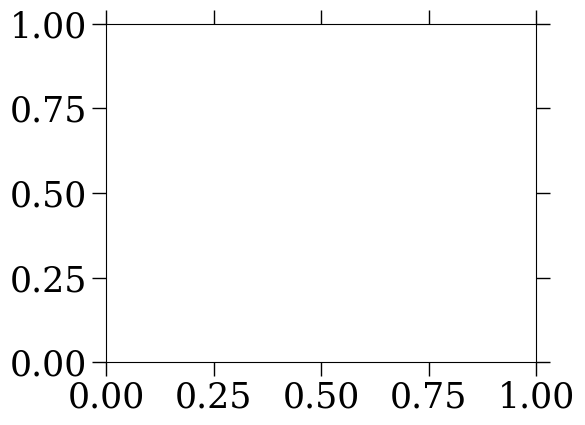

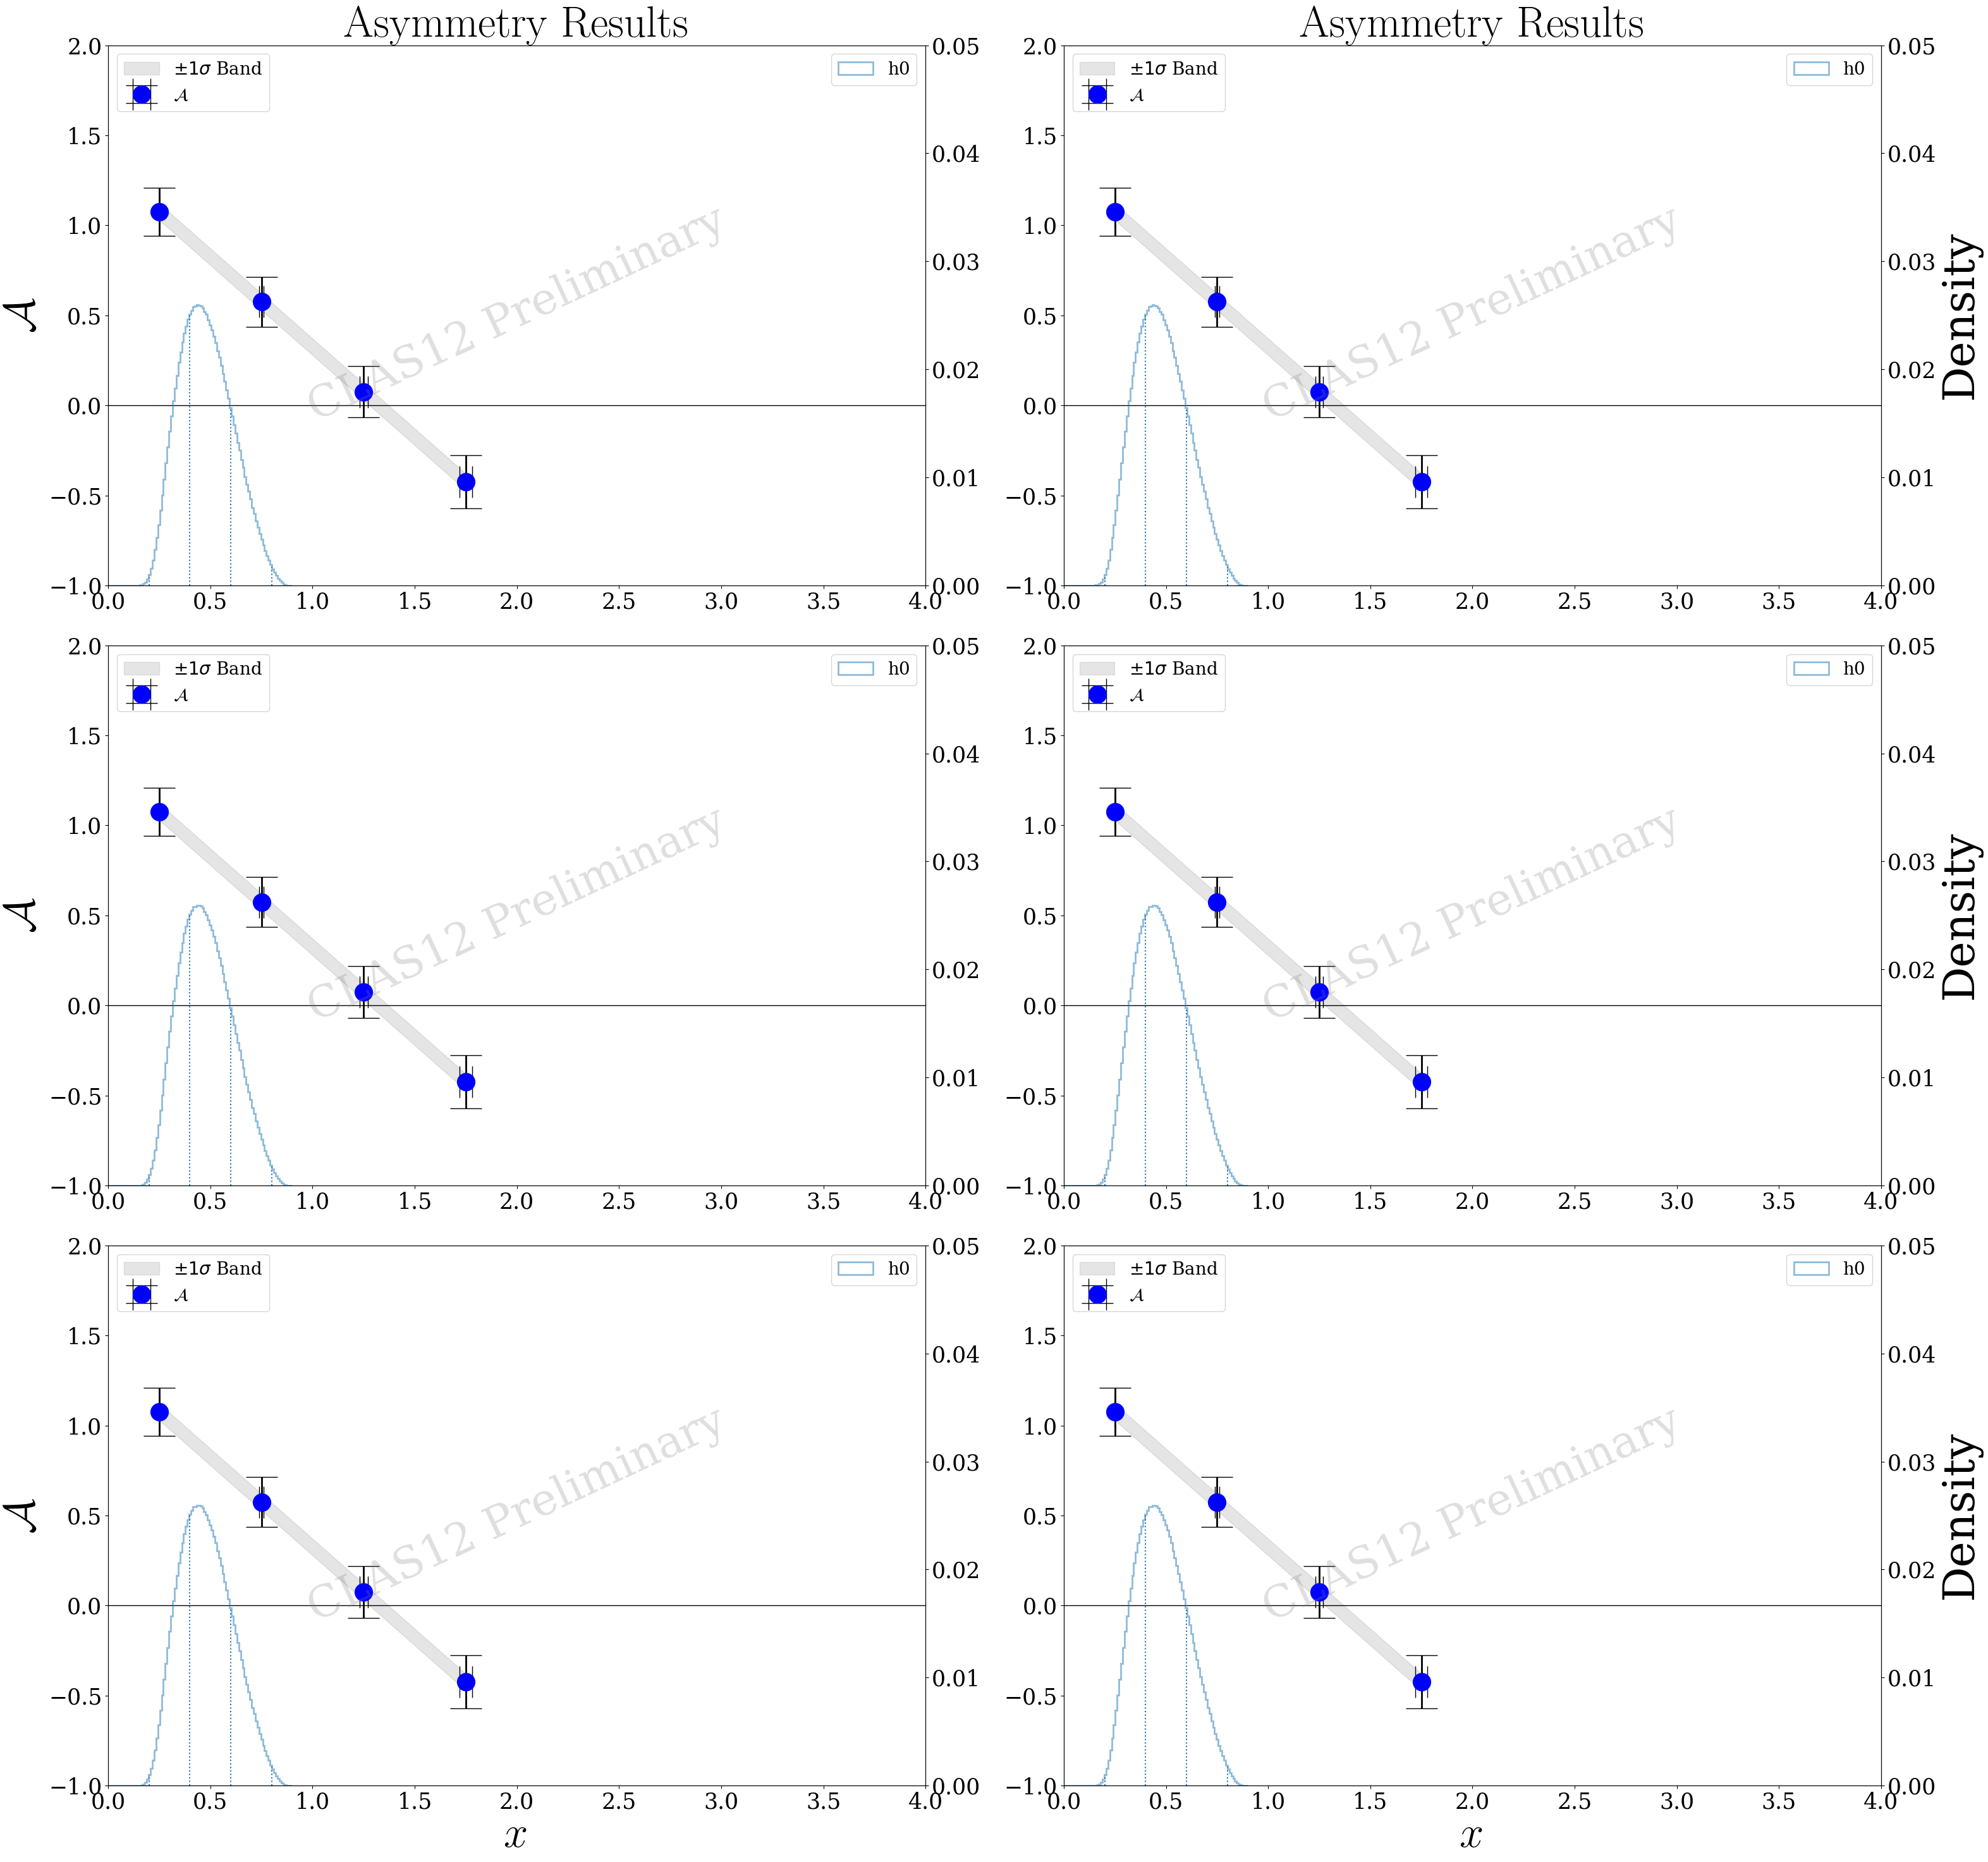

In [22]:
ncols, nrows = 3, 2
graph_matrix = [[graph for j in range(nrows)] for i in range(ncols)]
args_matrix = [[{'ylims':[-1.0,2.0],'xlims':[0.0,4.0]} for j in range(nrows)] for i in range(ncols)]
plot_results_kwargs_base = {
    'hist_paths':['/Users/mfm45/drop/getStatistics__10_22_24/h1_rga_dt_z_pipim.root'],
    'hist_keys':['h1_rga_dt_z_pipim'],
    'binlims':[0.0,0.2,0.4,0.6,0.8,1.0],
}
sagas.plot_results_array(graph_matrix,args_matrix,plot_results_kwargs_base=plot_results_kwargs_base,figsize=(32,30))

In [23]:
# TODO Correctly set twin y axis limits based on if lower limit of asymmetries is negative or not?

In [24]:
# TODO: Add histogram entries to the legend...

In [25]:
#TODO: Write example for pulling graphs for a 1/2D projection from file and configuration to graph list

DEBUGGING: config_list =  [{'method': 'HB', 'asymfitvars': 'costheta1'}, {'method': 'HB', 'asymfitvars': 'costheta2'}, {'method': 'LF', 'asymfitvars': 'costheta1'}, {'method': 'LF', 'asymfitvars': 'costheta2'}]
DEBUGGING: config  =  {'method': 'HB', 'asymfitvars': 'costheta1'}
DEBUGGING: out_dirs =  ['/Users/mfm45/saga/tutorials/results/asymfitvars_costheta1__inject_seed_1__method_HB', '/Users/mfm45/saga/tutorials/results/asymfitvars_costheta1__inject_seed_2__method_HB', '/Users/mfm45/saga/tutorials/results/asymfitvars_costheta1__inject_seed_4__method_HB', '/Users/mfm45/saga/tutorials/results/asymfitvars_costheta1__inject_seed_8__method_HB']
DEBUGGING: config_out_path =  /Users/mfm45/saga/tutorials/results/aggregate___inject_seed___asymfitvars_costheta1__method_HB___a0.pdf
DEBUGGING: out_file_names =  ['/Users/mfm45/saga/tutorials/results/asymfitvars_costheta1__inject_seed_1__method_HB/binscheme.csv', '/Users/mfm45/saga/tutorials/results/asymfitvars_costheta1__inject_seed_2__method_HB/

ValueError: 'x' is not 1-dimensional

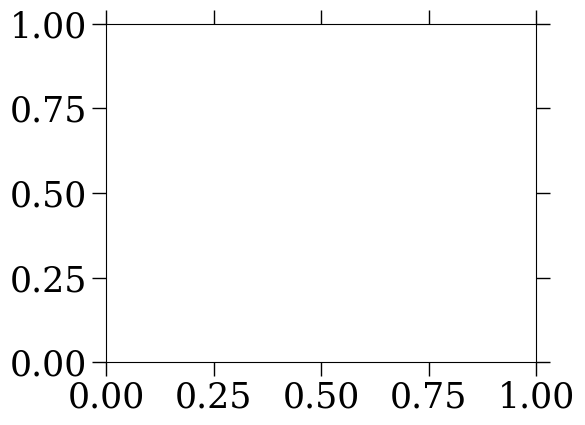

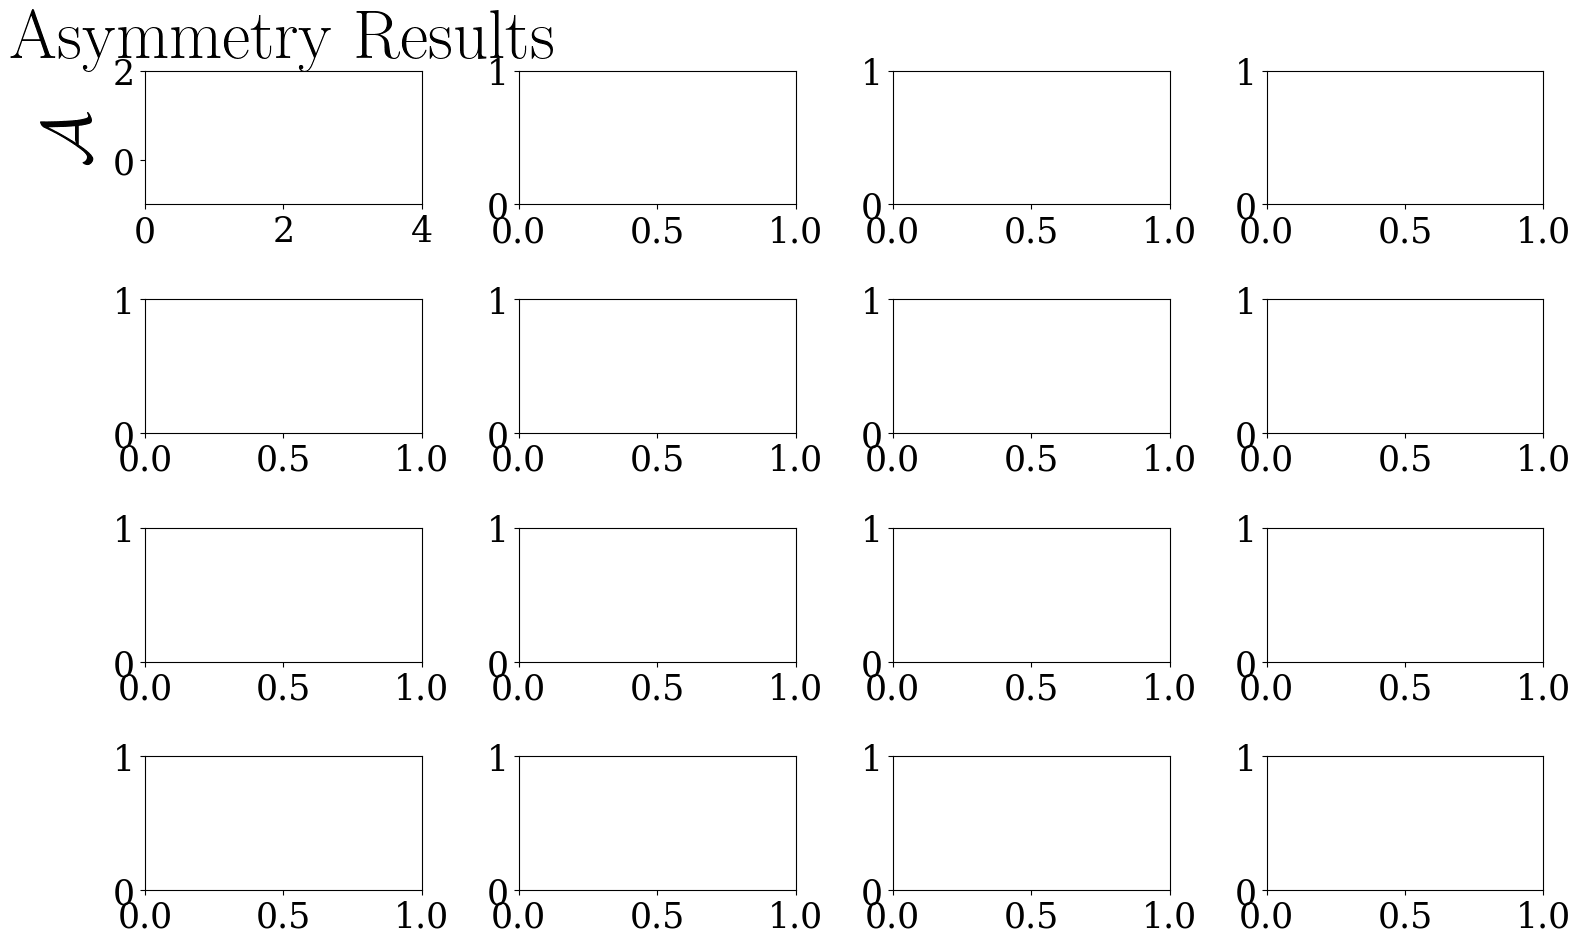

In [29]:
import os

# Setup configuration dictionary
methods = {"method":["HB","LF"]}
fitvars = {"asymfitvars":["costheta1","costheta2"]}
seeds   = {"inject_seed":[2**i for i in range(4)]}
configs = dict(
    methods,
    **fitvars,
    **seeds,
)

# Setup input paths
base_dir    = "/Users/mfm45/saga/tutorials/results/"
submit_path = os.path.join(base_dir,"submit.sh")
yaml_path   = os.path.join(base_dir,"args.yaml")
out_path    = os.path.join(base_dir,"jobs.txt")

# Set aggregate keys
aggregate_keys = ["inject_seed"]

# Get list of configurations
config_list = sagas.get_config_list(configs,aggregate_keys=aggregate_keys)

print("DEBUGGING: config_list = ",config_list)

# Get aggregated list of directories
out_dirs_list = sagas.get_out_dirs_list(
                                configs,
                                base_dir,
                                aggregate_keys=aggregate_keys
                            )

#---------- NOW Get more specific but ideally you would loop and do this for each aggregate list ---------#
# Set the config you are interested in
config = config_list[0]
out_dirs = out_dirs_list[0]

print("DEBUGGING: config  = ",config)
print("DEBUGGING: out_dirs = ",out_dirs)

# Set the output path basename for this config
result_name = "a0"
config_out_path = sagas.get_config_out_path(
        base_dir,
        aggregate_keys,
        result_name,
        config,
        sep='_',
        ext='.pdf',
    )

print("DEBUGGING: config_out_path = ",config_out_path)

# Get the name of the CSV file for the binning scheme you are interested in

binscheme_name = 'binscheme'
out_file_names = [sagas.get_out_file_name(
        base_dir=outdir,
        binscheme_name=binscheme_name,
        ext='.csv'
    ) for outdir in out_dirs]

print("DEBUGGING: out_file_names = ",out_file_names)

# Load a pandas dataframe from the file
dfs = [sagas.load_csv(out_file_name) for out_file_name in out_file_names]

# Now set the projection array you want to get
binschemes_name = "binschemes"
yaml_args = sagas.load_yaml(yaml_path)
binscheme = yaml_args[binschemes_name][binscheme_name]

print("DEBUGGING: binscheme : ",binscheme_name," = ",binscheme)

# Get bin scheme cuts and ids
id_key = 'bin_id'
binscheme_cuts, binscheme_ids = sagas.get_binscheme_cuts_and_ids(
                                                    binscheme,
                                                    start_idx=0,
                                                    id_key=id_key
                                                )

print("DEBUGGING: binscheme_cuts = ",binscheme_cuts)
print("DEBUGGING: binscheme_ids = ",binscheme_ids)

# Get projection bin ids
proj_vars = ['y','z']#NOT SURE ABOUT THIS ONE...
all_proj_ids, other_vars, all_proj_other_var_ids = sagas.get_projection_ids(
        binscheme_ids,
        proj_vars,
        id_key=id_key,
        other_var_bins={}
    )

print("DEBUGGING: all_proj_ids           = ",all_proj_ids)
print("DEBUGGING: other_vars             = ",other_vars)
print("DEBUGGING: all_proj_other_var_ids = ",all_proj_other_var_ids)

#TODO: Get array of graphs in projection #NOTE: HOW TO HANDLE 1/2D??? Might need another function
asym_key   = "a0"
err_ext    = 'err'
xvar_keys = ['x']
sgasym = 0.1
shape = np.shape(all_proj_ids)

gdata_0 = sagas.get_graph_data(
                        dfs[0],
                        all_proj_ids[0][0],
                        id_key,#TODO: Make this an optional argument too
                        xvar_keys=xvar_keys,
                        asym_key=asym_key,
                        err_ext=err_ext
            )

print("DEBUGGING: gdata_0 = ",gdata_0)

graph_array = [[
    sagas.get_aggregate_graph(
        [
            sagas.get_graph_data(
                        df,
                        all_proj_ids[i][j],
                        id_key,#TODO: Make this an optional argument too
                        xvar_keys=xvar_keys,
                        asym_key=asym_key,
                        err_ext=err_ext
            ) for df in dfs
        ],
        xvar_keys=xvar_keys,
        sgasym=sgasym
    ) for j in range(shape[1])] for i in range(shape[0])
]

# print("DEBUGGING: graph_array = ",graph_array)

#TODO: Plot an array of graphs
#TODO: Write method to correctly set cut labels???
plot_results_kwargs_array = [[{'ylims':[-1.0,2.0],'xlims':[0.0,4.0]} for j in range(nrows)] for i in range(ncols)]
plot_results_kwargs_base = {
    'hist_paths':['/Users/mfm45/drop/getStatistics__10_22_24/h1_rga_dt_z_pipim.root'], #TODO: Generate dummy histogram or include...
    'hist_keys':['h1_rga_dt_z_pipim'],
    'binlims':[0.0,0.2,0.4,0.6,0.8,1.0], #TODO: Set this from yaml args
}
sagas.plot_results_array(
        graph_array,
        plot_results_kwargs_array,
        plot_results_kwargs_base = {},
        figsize = (16,10),
        outpath = 'plot_projections.pdf',
        use_default_plt_settings = True,
    )


# # Load bin migration matrix from ROOT and save to CSV
# bin_migration_mat = sagas.load_th1(
#     path='h_bin_migration_2D_final_bins.root',
#     name='h2d_bin_migration_'+binvar
# )
# sagas.save_bin_migration_matrix_to_csv(bin_migration_mat) #NOTE: MUST BE A SQUARE MATRIX!

# # Compute systematics
# yerr_syst = sagas.compute_systematics(
#     arrs['y_mean'],
#     bin_migration_mat=None,#bin_migration_mat,
#     bin_migration_order=1,
#     systematic_scales_mat=systematic_scales_mat,
#     systematics_additive_mat=None,
# )
# print("DEBUGGING: AFTER: systematic_scales_mat = ",systematic_scales_mat)

# # Plot systematics
# labels = ['$\\alpha_{\Lambda}$','$P_{B}$','MC', 'Mass Fit','$\cos{\phi_{\Lambda}}$']

# # Get systematics all plotted stacked without results...
# sagas.plot_systematics(
#     arrs['x_mean'],
#     all_systematics,
#     palette = 'Dark2',
#     stacked = False,
#     label   = labels,
#     xlims   = xlimss[binvar],
#     ylims   = (-0.01,0.1),
#     xvar    = binvar,
#     title   = titles[fitvar],
#     xtitle  = xtitles[binvar],
#     # ytitle  = ytitle, #NOTE: LET THIS JUST BE DEFAULT FOR NOW.
#     outpath = outpath.replace('.pdf','__systematics.pdf'),
#     # yaml_args = yaml_args,
# )



In [ ]:
binvar_cols = [','.join([binvar,binvar+'err']) for binvar in binscheme.keys()]

In [ ]:
binvar_cols

In [ ]:
np.random.rand()

In [ ]:
import os
os.path.join('saga','')